## Imports

---



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
import plotly.figure_factory as ff
import plotly.graph_objects as go
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

from google.colab import files
import io
from IPython.display import clear_output
clear_output()


## Carga del dataset

In [3]:
uploaded = files.upload()

Saving Output_Tratamiento.csv to Output_Tratamiento.csv


In [4]:
df = pd.read_csv(io.BytesIO(uploaded['Output_Tratamiento.csv']))

### Preparación del Dataset para realizar el modelo supervisado (Random Forest)

### Variables numéricas ya listas:
age, study_hours_per_day, social_media_hours, netflix_hours,

attendance_percentage, sleep_hours, exercise_frequency, mental_health_rating.

### Variables categóricas que debemos codificar:


*   gender (Male/Female)
*   part_time_job (Yes/No)
*   diet_quality (Poor/Fair/Good)
*   parental_education_level (High School, Master...)
*   internet_quality (Poor/Average/Good)
*   extracurricular_participation (Yes/No)



### Usamos OneHotEncoder ya que las caracteristicas de las variables no siguen un orden y queremos evitar introducir errores

In [5]:
df.head()

,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,S1000,23,Female,0.0,1.2,1.1,No,85.0,8.0,Fair,6,Master,Average,8,Yes,56.2
1,S1001,20,Female,6.9,2.8,2.3,No,97.3,4.6,Good,6,High School,Average,8,No,100.0
2,S1002,21,Male,1.4,3.1,1.3,No,94.8,8.0,Poor,1,High School,Poor,1,No,34.3
3,S1003,23,Female,1.0,3.9,1.0,No,71.0,9.2,Poor,4,Master,Good,1,Yes,26.8
4,S1004,19,Female,5.0,4.4,0.5,No,90.9,4.9,Fair,3,Master,Good,1,No,66.4


In [6]:
df = df.drop(columns=["student_id"])

# separamos entre predictores y variable objetivo
X = df.drop('exam_score',axis = 1)
y = df['exam_score']

columnas_cat = [
    'gender', 'part_time_job', 'diet_quality',
    'parental_education_level', 'internet_quality',
    'extracurricular_participation'
]

# Aplicamos OneHotEncoding para 'Vectorizar' nuestras columnas categoricas

procesamiento = ColumnTransformer(
    transformers = [('categoria', OneHotEncoder(drop="first"), columnas_cat)],
    remainder='passthrough'
)

# Creamos un pipeline porque es mas facil llamarlo en vez de hacer la vectorizacion para cada columna cat

pipeline = Pipeline(steps=[
    ("Tratamiento", procesamiento),
    ("regressor", RandomForestRegressor(random_state=42))
])

# Separamos en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamos el modelo
pipeline.fit(X_train, y_train)

# Predecimos
y_pred = pipeline.predict(X_test)

### Evaluación del modelo

In [7]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.2f}")
print(f"R^2: {r2:.2f}")

MSE: 38.66
R^2: 0.85


### Podemos probar las regularizaciones de lasso(L1) y ridge(L2) y comparar con random forest para ver cual estima mejor:

In [8]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import GridSearchCV

In [9]:
param_grilla = [
    {
        "regressor": [Lasso()],
        "regressor__alpha": [0.01, 0.1, 1, 10]
    },
    {
        "regressor": [Ridge()],
        "regressor__alpha": [0.01, 0.1, 1, 10]
    },
    {
        "regressor": [RandomForestRegressor(random_state=42)],
        "regressor__n_estimators": [50, 100],
        "regressor__max_depth": [None, 10, 20]
    }
]

grid = GridSearchCV(pipeline, param_grilla, cv=5, scoring="neg_mean_squared_error")

In [10]:
grid.fit(X_train, y_train)

resultados = pd.DataFrame(grid.cv_results_)

#columnas utiles
cols_utiles = [
    "param_regressor", "param_regressor__alpha", "param_regressor__n_estimators",
    "param_regressor__max_depth", "mean_test_score", "rank_test_score"
]

# Mostrar solo las columnas relevantes
print(resultados[cols_utiles].sort_values("rank_test_score").head(15))

                           param_regressor  param_regressor__alpha  \
1                                  Lasso()                    0.10   
0                                  Lasso()                    0.01   
7                                  Ridge()                   10.00   
6                                  Ridge()                    1.00   
5                                  Ridge()                    0.10   
4                                  Ridge()                    0.01   
2                                  Lasso()                    1.00   
13  RandomForestRegressor(random_state=42)                     NaN   
9   RandomForestRegressor(random_state=42)                     NaN   
11  RandomForestRegressor(random_state=42)                     NaN   
12  RandomForestRegressor(random_state=42)                     NaN   
8   RandomForestRegressor(random_state=42)                     NaN   
10  RandomForestRegressor(random_state=42)                     NaN   
3                   

In [11]:
mejor_modelo = grid.best_estimator_
# Predecir sobre el conjunto de test
y_pred = mejor_modelo.predict(X_test)

# Calcular métricas
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Evaluación del mejor modelo en el set de test:")
print(f"MSE: {mse:.2f}")
print(f"R² : {r2:.2f}")

Evaluación del mejor modelo en el set de test:
MSE: 26.02
R² : 0.90


### Viendo el resumen de las 15 mejores combinaciones de modelo y parámetros probadas por GridSearchCV, ordenadas por desempeño (mejor rank_test_score). La primera fila (índice 1) es el mejor modelo:
Modelo: Lasso()

Alpha: 0.10

Mean Test Score: -29.73

(se suele usar el negativo del error cuadratico medio, mientras ams cerca a 0 mejor)



---



### Seleccinamos el mejor de cada modelo

In [12]:
mejores_modelos = {}

for modelo in ["Lasso", "Ridge", "RandomForest"]:
    mascara = resultados["param_regressor"].astype(str).str.contains(modelo)
    mejor = resultados[mascara].sort_values("rank_test_score").iloc[0]
    mejores_modelos[modelo] = mejor["params"]

### Rentrenamos y evaluamos cada modelo

In [13]:
from sklearn.metrics import mean_squared_error, r2_score

metricas = []

for nombre, params in mejores_modelos.items():
    # Extraer el modelo base
    modelo = params["regressor"]

    # Setear hiperparámetros
    for k, v in params.items():
        if k.startswith("regressor__"):
            setattr(modelo, k.split("__")[1], v)

    # Crear el pipeline
    pipe = Pipeline([
        ("preprocessing", procesamiento),
        ("regressor", modelo)
    ])

    # Entrenar y predecir
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    # Calcular métricas
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Guardar resultados
    metricas.append({
        "Modelo": nombre,
        "MSE": mse,
        "R²": r2
    })

In [14]:
df_metricas = pd.DataFrame(metricas)
print(df_metricas)

         Modelo        MSE        R²
0         Lasso  26.021890  0.898522
1         Ridge  26.448130  0.896860
2  RandomForest  38.661753  0.849230


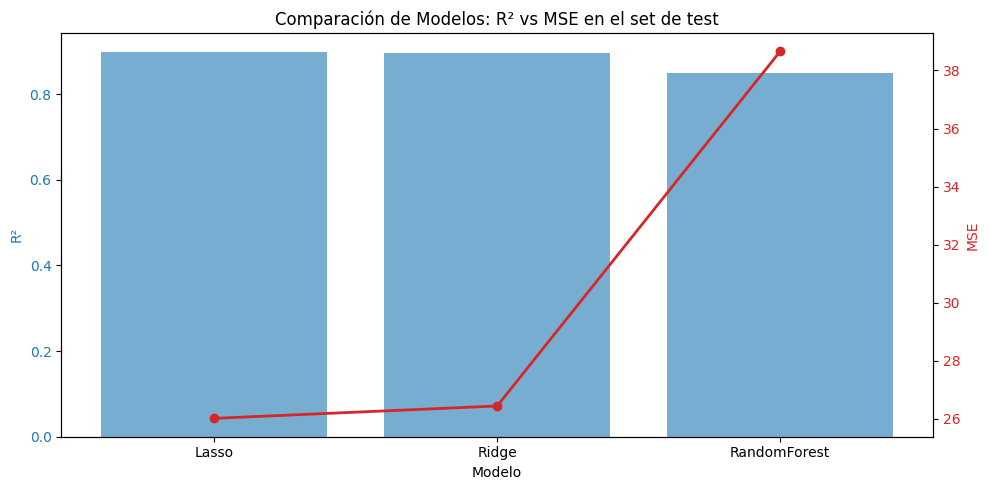

In [15]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# Eje 1: R² como barras
color = "tab:blue"
ax1.set_xlabel("Modelo")
ax1.set_ylabel("R²", color=color)
ax1.bar(df_metricas["Modelo"], df_metricas["R²"], color=color, alpha=0.6)
ax1.tick_params(axis="y", labelcolor=color)

# Eje 2: MSE como línea
ax2 = ax1.twinx()  # Segundo eje y
color = "tab:red"
ax2.set_ylabel("MSE", color=color)
ax2.plot(df_metricas["Modelo"], df_metricas["MSE"], color=color, marker="o", linewidth=2)
ax2.tick_params(axis="y", labelcolor=color)

# Título
plt.title("Comparación de Modelos: R² vs MSE en el set de test")
fig.tight_layout()
plt.show()